In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
 

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as stats

## Read in  Data:

In [2]:
df = pd.read_csv('./Data/cat_clean.csv')

In [3]:
df.describe()

,Age,Gender,Neuter_status,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem
count,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5689.000000
mean,4.752602,1.539326,0.779670,4.619031,2.547753,0.847788,3.770190,4.088834,1.116397,1.096559,1.583743,2.025632,1.884480,1.789150,0.912395,1.070487
std,3.768478,0.498495,0.414506,1.576234,1.911887,0.359258,0.864699,0.878686,0.418163,0.368394,0.839547,0.996769,1.051775,0.997606,1.544499,0.384916
min,0.167100,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.789000,1.000000,1.000000,4.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
50%,3.886300,2.000000,1.000000,4.000000,2.000000,1.000000,4.000000,4.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000
75%,6.778100,2.000000,1.000000,5.000000,5.000000,1.000000,4.000000,5.000000,1.000000,1.000000,2.000000,3.000000,2.000000,3.000000,2.000000,1.000000
max,24.811000,2.000000,1.000000,8.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,7.000000,3.000000


**Notes:**  
* I'm not sure if I will scale the age column for my distance-based classifiers. I feel like doing so will lose an aspect of interpretability if the goal here is to be able to predict if a cat you're going to adopt would be a wool-sucker or not. However, I do understand the importance of magnitiude in algorithms of that nature. 
* I am going to reocde `Behaviour_problem` as a binary of yes or no (compared to I don't know, no, yes dx'd by vet, yes dx'd by self). 
* I will try to do both multiclass and binary classification with wool sucking but I fear I won't have enough data to get much worth out of a multiclass classifier.
* I will try three flavors of logistic regression (binary, multiclass, ordinal). Two of random forest (binary, multiclass). And four KNN (binary, binary with age scaled, multiclass, multiclass with age scaled). 

# Preprocessing:

In [4]:
# Recode Behaviour_problem to binary
df['Behaviour_problem'].replace([1, 2, 3], [0, 1, 1], inplace=True)
df['Behaviour_problem'].value_counts()

0.0    5193
1.0     496
Name: Behaviour_problem, dtype: int64

In [5]:
# BINARY DATA SET
df_bin = df
# 0-2 = no sucking, 3-7 = sucking 
df_bin['ws_binary'] = df_bin['Wool_sucking'].replace({1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:1})
df_bin.drop(columns='Wool_sucking', inplace=True)
df_bin.head()

# one-hot breed (note: get_dummies one-hots by default rather than genuine dummy variables w n-1 columns)
pd.get_dummies(df_bin, columns=['Breed_group'], prefix='B', inplace=True)
df_bin.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5696 non-null   float64
 1   Gender               5696 non-null   int64  
 2   Neuter_status        5696 non-null   int64  
 3   Weaning_age          5696 non-null   int64  
 4   Outdoors             5696 non-null   int64  
 5   Other_cats           5696 non-null   int64  
 6   Activity_level       5696 non-null   int64  
 7   Contact_people       5696 non-null   int64  
 8   Aggression_stranger  5696 non-null   int64  
 9   Aggression_owner     5696 non-null   int64  
 10  Aggression_cats      5696 non-null   int64  
 11  Shyness_novel        5696 non-null   int64  
 12  Shyness_strangers    5696 non-null   int64  
 13  Grooming             5696 non-null   float64
 14  Behaviour_problem    5689 non-null   float64
 15  ws_binary            5696 non-null   f

In [6]:
# Assign BINARY X and y
X_bin = df_bin.drop(columns='ws_binary')
y_bin = df_bin['ws_binary']

In [10]:
# MULTICLASS DATA SET 
df_multi = df
# one-hot breed (note: get_dummies one-hots by default rather than genuine dummy variables w n-1 columns)
pd.get_dummies(df_multi, columns=['Breed_group'], prefix='B', inplace=True)
df_multi.describe()

In [6]:
# Assign MULTICLASS X and y
X_multi = df_multi.drop(columns='Wool_sucking')
y_multi = df_multi['Wool_sucking']

,Age,Gender,Neuter_status,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,...,B_MCO,B_NFO,B_ORI,B_PER,B_RAG,B_RUS,B_SBI,B_SIB,B_TUV,B_other
0,4.0274,2,1,8,0,1,4,5,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2.1096,2,1,8,0,1,5,4,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7.6822,1,1,4,0,1,4,5,1,1,...,0,0,0,0,0,0,0,0,0,0
3,5.0027,1,1,4,4,0,5,5,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5.0137,1,1,4,5,1,4,5,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,11.1151,1,1,4,3,1,3,5,1,1,...,0,1,0,0,0,0,0,0,0,0
5722,6.3644,1,0,4,5,1,4,3,1,1,...,0,1,0,0,0,0,0,0,0,0
5723,3.1205,1,1,4,4,1,4,5,1,1,...,0,1,0,0,0,0,0,0,0,0
5724,3.6274,1,1,5,1,1,5,3,1,1,...,0,1,0,0,0,0,0,0,0,0


In [14]:
# I already know y has some serious class imablance, hence stratify
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, test_size=0.3, random_state=42, stratify=y)

X_trains, X_tests, y_trains, y_tests = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42, stratify=y)


# DO SCALING AFTER THIS STEP !!!!
'''# get age on scale of 0-5 which is about where everyone else
scaler = MinMaxScaler(feature_range=(0,5))
scaled_age = scaler.fit_transform(encoded_df['Age'].values.reshape(-1, 1))
encoded_df['scaled_age'] = scaled_age
encoded_scaled_df = encoded_df.drop(columns='Age')'''

# Training and testing :))))

## Logistic Regression:
I expect binary to perform the best as I don't think we have enough data here to make a model with good predictive value. 

### Binary:

In [ ]:
# BINARY - no scaling as logistic regression is not sensitive to magnitude 

# Instantiate model
log = LogisticRegression()

# Fit model
log.fit(X_train, y_train)

# Calculate Predictions and Predicted Probabilities
y_pred_probs = log.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

In [ ]:
# Graph ROC with AUC
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log Reg ROC Curve - Binary")
plt.show();

In [ ]:
# Confusion Matrix with Metrics (accuracy, precision, recall, f-1)

\[insert interpretations\]

### Multiclass:

In [ ]:
# MULTICLASS 

# Instantiate model
logs = LogisticRegression()

# Fit model
logs.fit(X_trains, y_trains)

# Calculate Prediction and Predicted Probabilities
y_pred_probss = logs.predict_proba(X_tests)[:,1]
fprs, tprs, thresholdss = roc_curve(y_tests, y_pred_probss)

In [ ]:
# Graph ROC with AUC
plt.plot([0,1], [0,1], 'k--')
plt.plot(fprs, tprs)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_tests, y_pred_probss):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log Reg ROC Curve - Multiclass")
plt.show();

In [ ]:
# Confusion Matrix 

In [ ]:
# Metrics (accuracy, precidion, recall, f-1)
accuracy = accuracy_score(y_tests, y_preds)
precision = precision_score(y_tests, y_preds, average='macro')
recall = recall_score(y_tests, y_preds, average='macro')
f1 = f1_score(y_tests, y_preds, average='macro')

\[insert interpretations\]

### Ordinal:

In [ ]:
# ORDINAL
import statsmodels.api as sm

# Add constant to training
X_trains = sm.add_constant(X_trains)

# Instantiate model
ordinal_model = sm.MNLogit(y_trains, X_trains)

# Fit model
ordinal_results = ordinal_model.fit_regularized(method='l1', alpha=0.5)

# Add constant to testing 
X_test = sm.add_constant(X_test)

# Calculate Predictions and Predicted Probabilities 
y_pred = ordinal_results.predict(X_test)
y_pred = y_pred.idxmax(axis=1)  # Convert predicted probabilities to class labels

'''LOOK AT THIS ^ BEFORE YOU RUN IT, I'M NOTE SURE IT'S READY TO GO'''

In [ ]:
# Graph ROC with AUC

In [ ]:
# Confusion Matrix

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score([], [])
precision = precision_score([], [], average='macro')
recall = recall_score([], [], average='macro')
f1 = f1_score([], [], average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

\[insert interpretations\]

### Parameter Tuning:
As expected, the binary performed the best. Next I will conduct a grid search with `log`.

In [11]:
param_grid = {
    'C': [0.01, 0.1, 'none'],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [1000, 1500, 2000]
}

grid_search = GridSearchCV(log, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X, y)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

Best Hyperparameters:  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score:  0.6667001110663829


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Va

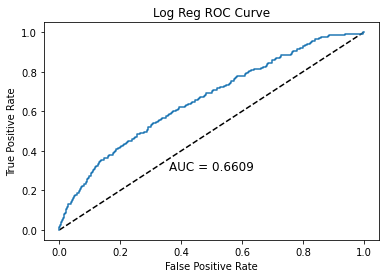

In [19]:
# re-plot w tuned parameters
log_tuned = LogisticRegression(C=0.1, max_iter=1000, penalty='l2', solver='lbfgs')
log_tuned.fit(X_train, y_train)

y_pred_tuned = log_tuned.predict(X_test)
y_pred_probs_tuned = log_tuned.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_tuned)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs_tuned):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log Reg ROC Curve - Binary, Tuned")
plt.show();

Slightly better! Hoorah!

## Random Forest:
This algorithm is also not sensitive to magnitude so I will not be scaling. I would think Random Forest would be my best bet at muticlass of the three, but I still don't have high hopes. 

### Binary:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
# binary run

# instantiate the model 
rf = RandomForestClassifier()

# fit the model
rf.fit(X_train, y_train)

# predict and predicted probs 
y_pred = rf.predict(X_test)

Accuracy: 0.8132635253054101
Precision: 0.5777777777777777
Recall: 0.5094534734762544
F1-score: 0.47886066911464703


In [ ]:
# ROC

In [ ]:
# Confusion Matrix

In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

### Multiclass:

In [25]:
# multiclass run

# instantiate the model
rfs = RandomForestClassifier()

# fit the model
rfs.fit(X_trains, y_trains)

# predicted and predicted probs
y_preds = rfs.predict(X_tests)

Accuracy: 0.6841186736474695
Precision: 0.31264222503160555
Recall: 0.15227135340795286
F1-score: 0.1363710150595602


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# ROC

In [ ]:
# Confusion Matrix

In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_tests, y_preds)
precision = precision_score(y_tests, y_preds, average='macro')
recall = recall_score(y_tests, y_preds, average='macro')
f1 = f1_score(y_tests, y_preds, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Woof, yeah even a tried and true ensemble poster boy can't multiclass with these few points :( 

### Parameter Tuning:
On the binary model, of course. 

In [42]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5)

grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.819371727748691
Precision: 0.0
Recall: 0.0
F1-score: 0.0


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Yeah... not sure what happened here but I don't think this is the best set of parameters...

For reference, the tuned log got:  
Evaluation Scores:  
Accuracy: 0.8207217694994179  
Precision: 0.6970992622401073  
Recall: 0.5107725439882698  
F1-score: 0.47520549684217206  

About neck and neck! Let's see if KNN can bring any real competition. 

## KNN:
KNN is a distance-based algorithm, so I would assume scaling would increase performance. I still don't think I have enough data for multiclass prediction.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### Binary

In [28]:
# KNN - BINARY

# instantiate model
knn = KNeighborsClassifier()

# I'm not sure what a good value for k would be, so let's start off with parameter tuning this time 
param_grid = {'n_neighbors':[3, 5, 7, 9]}
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit it
grid_search.fit(X_trains, y_trains)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

# Predicted and predicted probabilities
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best Parameters: {'n_neighbors': 9}
Accuracy: 0.8131548311990687
Precision: 0.37209302325581395
Recall: 0.05161290322580645
F1-score: 0.0906515580736544


In [ ]:
# ROC 

In [ ]:
# Confusion Matrix

In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

### Binary - Age Scaled

In [ ]:
# scale data


In [ ]:
# instantiate model

# instantiate grid search

# optimal estimator

# predict and probabilities

In [ ]:
# ROC 

In [ ]:
# Confusion Matrix

In [ ]:
# Evaluation Metrics

### Multiclass

### Multiclass - Age Scaled 

In [37]:
#scale data
scaler = MinMaxScaler(feature_range=(0,8))
scaled_age = scaler.fit_transform(encoded_df_multi['Age'].values.reshape(-1, 1)) # (makes it a 2D array)
encoded_scaled_multi['scaled_age'] = scaled_age
encoded_scaled_multi = encoded_df_multi.drop(columns='Age')

In [40]:
# multiclass KNN 

knn_m = KNeighborsClassifier()

param_grid = {'n_neighbors':[3, 5, 7, 9]}
grid_search = GridSearchCV(knn_m, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'n_neighbors': 9}
Accuracy: 0.6792782305005821
Precision: 0.1421358543417367
Recall: 0.12663655611828933
F1-score: 0.1068749305875759


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# ROC 

In [ ]:
# Confusion Matrix

In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

As to be expected! Multiclass is not doing so hot with this small of a set. 

# Recap:

Only the binary classifiers did a good job! We tried Logistic Regression, a Random Forest, and KNN.

*** insert metrics *** 

We will be carrying on with the following model:

In [7]:
# save model like you did in the guided capstone. 